<a href="https://colab.research.google.com/github/mdietrichstein/plant-pathology-2020-fgvc7/blob/master/Plant_Pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [2]:
!pip install livelossplot

In [0]:
%matplotlib inline

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from livelossplot import PlotLossesKerasTF

tf.__version__

'2.2.0-rc4'

In [0]:
RANDOM_SEED = 1234

def set_random_seed(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
NUM_CLASSES = 4

# RUN_NAME = "inception_resnet_v2"
# BATCH_SIZE = 16
# PRETRAINED_MODEL_URL = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4"
# PRETRAINED_MODEL_ARGS = dict(batch_norm_momentum=0.997)
# INPUT_DIM = 299

RUN_NAME = "efficientnet_b3_2"
BATCH_SIZE = 16
PRETRAINED_MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1"
PRETRAINED_MODEL_ARGS = None
INPUT_DIM = 300

PADDED_DIM = INPUT_DIM + (INPUT_DIM // 4)

NUM_CHANNELS = 3

MODELS_PATH = Path("/content/drive/My Drive/Models/plant-pathology")
CHECKPOINT_PATH = MODELS_PATH / RUN_NAME
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

In [11]:
tf.executing_eagerly()

True

In [9]:
!cd "/content/drive/My Drive/Datasets/" && unzip plant-pathology-2020-fgvc7.zip -d /tmp/

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: /tmp/images/Test_0.jpg  
  inflating: /tmp/images/Test_1.jpg  
  inflating: /tmp/images/Test_10.jpg  
  inflating: /tmp/images/Test_100.jpg  
  inflating: /tmp/images/Test_1000.jpg  
  inflating: /tmp/images/Test_1001.jpg  
  inflating: /tmp/images/Test_1002.jpg  
  inflating: /tmp/images/Test_1003.jpg  
  inflating: /tmp/images/Test_1004.jpg  
  inflating: /tmp/images/Test_1005.jpg  
  inflating: /tmp/images/Test_1006.jpg  
  inflating: /tmp/images/Test_1007.jpg  
  inflating: /tmp/images/Test_1008.jpg  
  inflating: /tmp/images/Test_1009.jpg  
  inflating: /tmp/images/Test_101.jpg  
  inflating: /tmp/images/Test_1010.jpg  
  inflating: /tmp/images/Test_1011.jpg  
  inflating: /tmp/images/Test_1012.jpg  
  inflating: /tmp/images/Test_1013.jpg  
  inflating: /tmp/images/Test_1014.jpg  
  inflating: /tmp/images/Test_1015.jpg  
  inflating: /tmp/images/Test_1016.jpg  
  inflating: /tmp/images/Test_1017.jpg  
  inflating: /tmp/images/T

## Dataset Loading

In [0]:
!mkdir /tmp/output

In [0]:
INPUT_BASE_PATH = Path("/tmp/")
IMAGES_PATH = INPUT_BASE_PATH / "images"

TRAIN_CSV_PATH = INPUT_BASE_PATH / "train.csv"
TEST_CSV_PATH = INPUT_BASE_PATH / "test.csv"

OUTPUT_BASE_PATH = Path("/tmp/output")

assert IMAGES_PATH.exists()
assert TRAIN_CSV_PATH.exists()
assert TEST_CSV_PATH.exists()
assert OUTPUT_BASE_PATH.exists()

In [14]:
!ls /tmp/images/ | wc -l

3642


In [15]:
train_csv = pd.read_csv(TRAIN_CSV_PATH)
train_csv.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [0]:
data = np.array(
    list(map(lambda row: (str(IMAGES_PATH / f"{row[1][0]}.jpg"), np.argmax(row[1][1:])), train_csv.iterrows())))

data, labels = data[:, 0], (data[:, 1])

train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=RANDOM_SEED, stratify=labels)
train_data = np.vstack((train_data.T, train_labels.T)).T
valid_data = np.vstack((valid_data.T, valid_labels.T)).T

In [17]:
print(len(train_data))
print(len(valid_data))

1638
183


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_data)

In [0]:
def extract_label(row):
    return row[0], int(row[1])

def read_image(file_path, label):
    image_bytes = tf.io.read_file(file_path)
    return tf.image.decode_jpeg(image_bytes,channels=3), label

def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # cast and normalize the image to [0,1]
    return image, label

def resize(image, label):
      # image = tf.image.resize_with_crop_or_pad(image, PADDED_DIM, PADDED_DIM) 
    image = tf.image.resize_with_pad(image, PADDED_DIM, PADDED_DIM)
    return image, label

def augment(image, label):
    image = tf.image.random_crop(image, size=[INPUT_DIM, INPUT_DIM, NUM_CHANNELS])
    # image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_contrast(image, 0.8, 1)
    # image = tf.image.random_saturation(image, 0.8, 1)
    # image = tf.image.random_hue(image, 0.1)
    image = tf.reshape(image, (INPUT_DIM, INPUT_DIM, NUM_CHANNELS))
    return image, tf.reshape(label, (1,))

labeled_train_dataset = train_dataset.map(extract_label,
          num_parallel_calls=tf.data.experimental.AUTOTUNE).map(read_image).map(normalize).map(resize).map(augment)

labeled_valid_dataset = valid_dataset.map(extract_label,
          num_parallel_calls=tf.data.experimental.AUTOTUNE).map(read_image).map(normalize).map(resize)

In [0]:
def show_image(original, augmented=None):
    fig = plt.figure(figsize=(18, 9))
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    if augmented is not None:
        plt.subplot(1,2,2)
        plt.title('Augmented image')
        plt.imshow(augmented)

In [21]:
labeled_train_dataset

<MapDataset shapes: ((300, 300, 3), (1,)), types: (tf.float32, tf.int32)>

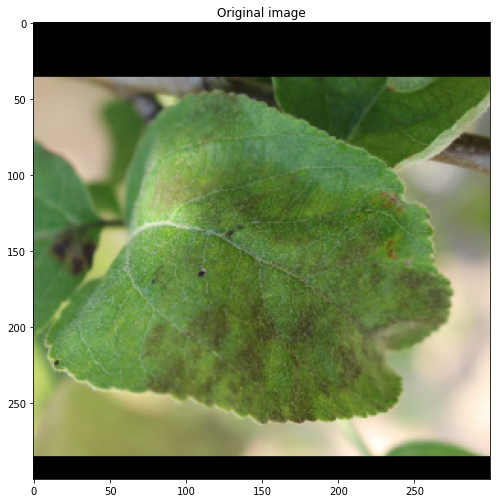

In [22]:
for f, l in labeled_train_dataset.take(1):
    show_image(f)

## Model

In [23]:
import tensorflow_hub as hub
hub.__version__

'0.8.0'

In [0]:
feature_extraction_layer = hub.KerasLayer(
    PRETRAINED_MODEL_URL, trainable=True, arguments=PRETRAINED_MODEL_ARGS
)

# hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b4/classification/1", trainable=True)


In [25]:
model = tf.keras.Sequential([feature_extraction_layer, tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")])
model.build([None, INPUT_DIM, INPUT_DIM, NUM_CHANNELS])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  10783528  
_________________________________________________________________
dense (Dense)                multiple                  6148      
Total params: 10,789,676
Trainable params: 10,702,380
Non-trainable params: 87,296
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['acc'])

In [0]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(CHECKPOINT_PATH),
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

plotlosses_callback = PlotLossesKerasTF()

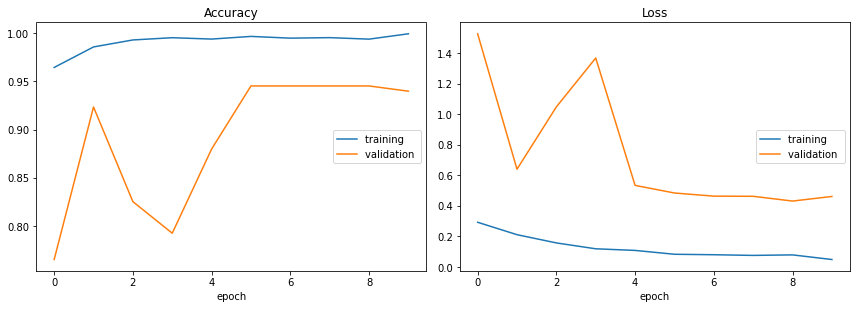

Accuracy
	training         	 (min:    0.965, max:    1.000, cur:    1.000)
	validation       	 (min:    0.765, max:    0.945, cur:    0.940)
Loss
	training         	 (min:    0.048, max:    0.292, cur:    0.048)
	validation       	 (min:    0.431, max:    1.526, cur:    0.461)
1638/1638 [==============================] - 594s 363ms/step - loss: 0.0482 - acc: 0.9995 - val_loss: 0.4610 - val_acc: 0.9399


In [28]:
model.fit(
    labeled_train_dataset.batch(BATCH_SIZE).cache().repeat().shuffle(500).prefetch(tf.data.experimental.AUTOTUNE),
    validation_data=labeled_valid_dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE),
    epochs=10,
    # steps_per_epoch=10,
    # validation_steps=10,
    steps_per_epoch=len(train_data) * 1,
    validation_steps=len(valid_data),
    callbacks=[checkpoint_callback, plotlosses_callback],
    verbose=1
)

In [29]:
test_csv = pd.read_csv(TEST_CSV_PATH)
test_csv.head(5)

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [0]:
test_data = np.array(
    list(map(lambda row: str(IMAGES_PATH / f"{row[1][0]}.jpg"), test_csv.iterrows())))

In [31]:
print(len(test_data))

1821


In [32]:
test_data[0]

'/tmp/images/Test_0.jpg'

In [0]:
def fake_label(image):
  return image, 0

test_dataset = tf.data.Dataset.from_tensor_slices(test_data).map(fake_label).map(read_image).map(normalize).map(resize)

In [34]:
test_dataset

<MapDataset shapes: ((375, 375, 3), ()), types: (tf.float32, tf.int32)>

In [35]:
predictions = model.predict(test_dataset.batch(BATCH_SIZE), verbose=1)

114/114 [==============================] - 39s 342ms/step


In [36]:
predictions

array([[2.4852023e-16, 1.5798447e-12, 1.0000000e+00, 9.0471705e-18],
       [1.2831433e-06, 1.1506340e-05, 9.9998724e-01, 3.2054788e-09],
       [8.0357568e-13, 2.4760106e-07, 3.0124674e-16, 9.9999976e-01],
       ...,
       [1.6139301e-06, 3.1926879e-04, 9.9967909e-01, 6.7389379e-09],
       [9.9999833e-01, 3.2198120e-08, 1.6337735e-06, 4.5210452e-08],
       [8.3762243e-06, 8.8972226e-04, 4.0663712e-09, 9.9910188e-01]],
      dtype=float32)

In [0]:
pd.options.display.float_format = "{}".format

results_df = pd.DataFrame({
    "image_id":  test_csv["image_id"].to_numpy(),
    "healthy":  predictions[:, 0],
    "multiple_diseases":  predictions[:, 1],
    "rust":  predictions[:, 2],
    "scab":  predictions[:, 3],
}, columns = ["image_id", "healthy", "multiple_diseases", "rust", "scab"])

results_df.round(2).to_csv(str(MODELS_PATH / f"submission_{RUN_NAME}.csv"), index=False)